In [1]:
#Import dependencies

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
%matplotlib notebook
import IPython
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
import copy
import skimage as ski
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
sys.path.append("../Manjari/STalign/STalign")
import STalign_nocontrast as STalign
STalign.hi5()

hi1


In [3]:
imagefile = 'aba_nissl.nrrd'
labelfile = 'aba_annotation.nrrd'

In [4]:
# Open image
filename = 'hyopil_2.jpg'
W = ski.io.imread(filename)
print(W.shape)

(5664, 4792, 3)


Pre-Processing

In [5]:
W_ = np.max(W) - W
W_ = ski.color.rgb2gray(W_) #then to gray scale
W_ = (W_ - np.min(W_))/(np.max(W_) - np.min(W_)) #then normalize

(5664, 4792)
(6264, 5392)


<IPython.core.display.Javascript object>


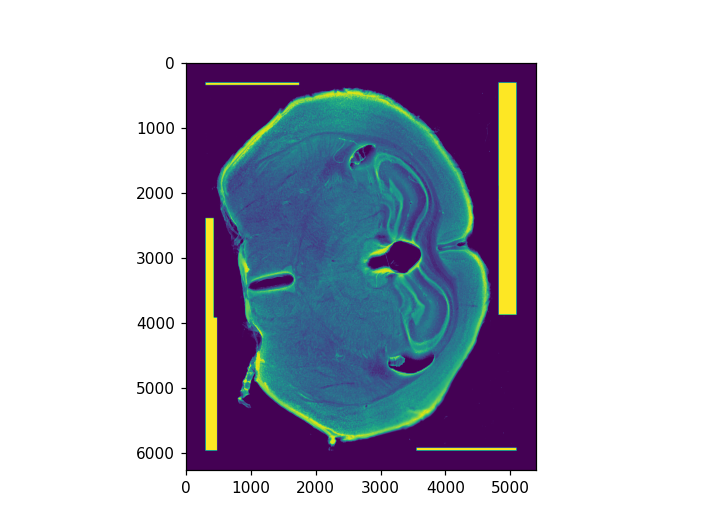

(6264, 5392)


<IPython.core.display.Javascript object>


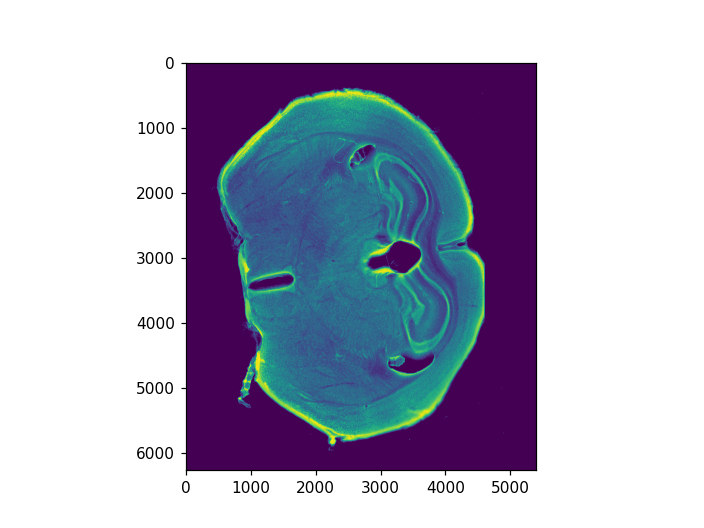

In [6]:
# PADDING FOLLOWD BY BRIGHT SPOT ELIMINATION
# add padding of 700 rows/cols
pad = 300
W__ = np.pad(W_,((pad,pad),(pad,pad)),'minimum')

print(W_.shape)
print(W__.shape)

fig,ax = plt.subplots()
ax.imshow(W__)

# manually set the bright squares to 0
W__[:pad+80,:pad+1550] = 0
W__[pad+2000:,:pad+240] = 0
W__[:pad+3700,pad+4300:] = 0
W__[pad+5500:,pad+3200:] = 0
print(W__.shape)

fig,ax = plt.subplots()
ax.imshow(W__)
#print(W__[5500:,3200:])

<IPython.core.display.Javascript object>


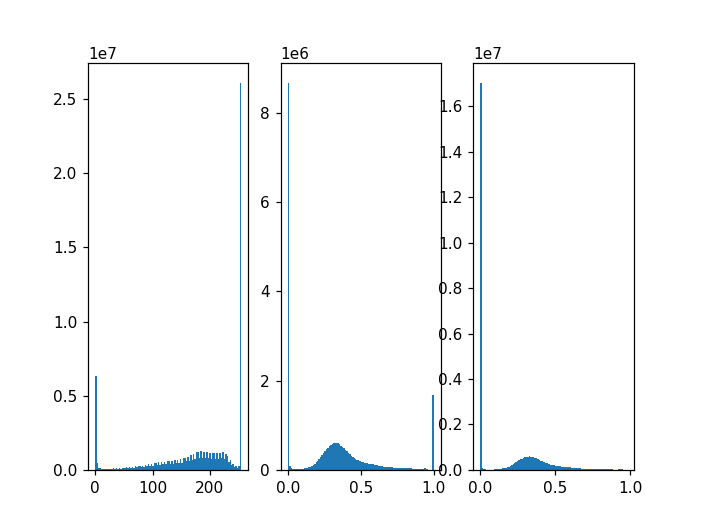

In [7]:
# Intensity Histogram
fig,ax = plt.subplots(1,3)
ax[0].hist(W.ravel(),bins=100);
ax[1].hist(W_.ravel(),bins=100);
ax[2].hist(W__.ravel(),bins=100);

<IPython.core.display.Javascript object>


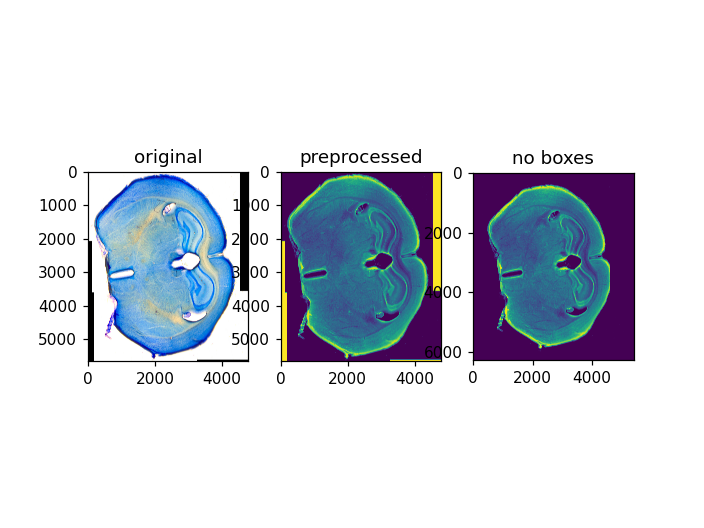

Text(0.5, 1.0, 'no boxes')

In [8]:
# Display image
fig,ax = plt.subplots(1,3)
ax[0].imshow(W,  origin='lower')
ax[0].invert_yaxis()
ax[0].set_title('original')

ax[1].imshow(W_,  origin='lower')
ax[1].invert_yaxis()
ax[1].set_title('preprocessed')

ax[2].imshow(W__,  origin='lower')
ax[2].invert_yaxis()
ax[2].set_title('no boxes')

(6264, 5392)
7
(895, 771)


<IPython.core.display.Javascript object>


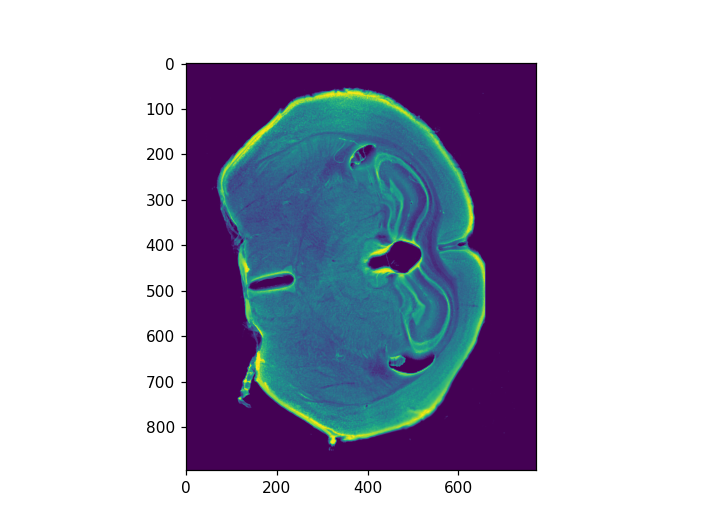

In [9]:
# setting W equal to the preprocessed image, including downscaling
print(W__.shape)
ds_factor = np.min(W__.shape) / 700 #factor to downscale by
ds_factor = int(ds_factor)
print(ds_factor)
W = ski.transform.downscale_local_mean(W__, (ds_factor, ds_factor)) # downsample
print(W.shape)

# plot W to ensure correctness
fig,ax = plt.subplots()
ax.imshow(W)

Prep for STalign

<IPython.core.display.Javascript object>


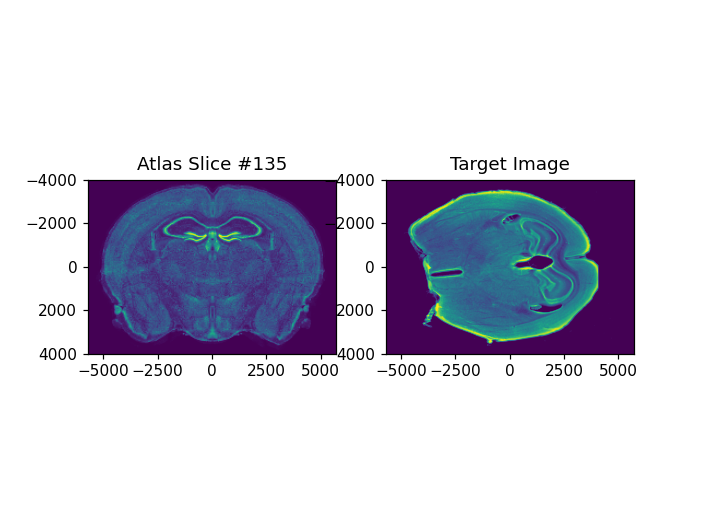

In [10]:
#find slice
#peruse through images in atlas
# Loading the atlas
import time

# stalign seems to use slice+10, not sure why
slice = 135


vol,hdr = nrrd.read(imagefile)
A = vol
vol,hdr = nrrd.read(labelfile)
L = vol

dxA = np.diag(hdr['space directions'])
nxA = A.shape
xA = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxA,dxA)]
XA = np.meshgrid(*xA,indexing='ij')

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(A[slice],extent=extentA)
ax[0].set_title(f'Atlas Slice #{slice}')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

<IPython.core.display.Javascript object>


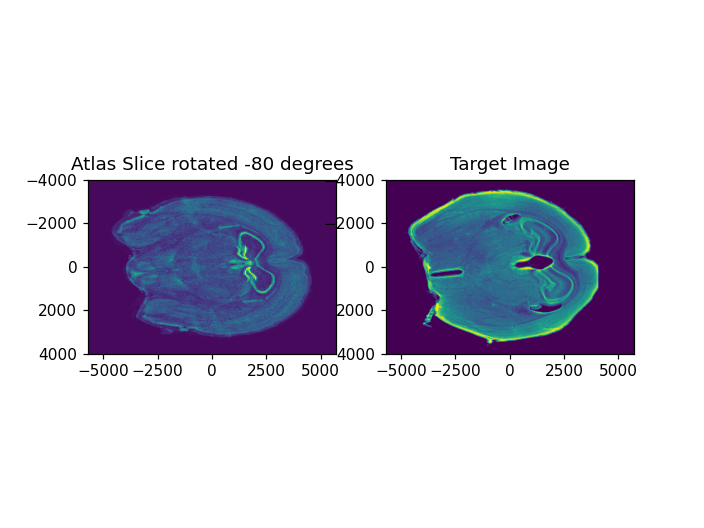

In [11]:
#find rotation
from scipy.ndimage import rotate

theta_deg = -80

fig,ax = plt.subplots(1,2)
extentA = STalign.extent_from_x(xA[1:])
ax[0].imshow(rotate(A[slice], angle=theta_deg),extent=extentA)
ax[0].set_title(f'Atlas Slice rotated {theta_deg} degrees')

ax[1].imshow(W,extent=extentA)
ax[1].set_title('Target Image')
fig.canvas.draw()

In [12]:
X_ = np.arange(0,W.shape[1])
Y_ = np.arange(0,W.shape[0])
xJ = [Y_,X_]
J = W[None]/np.mean(np.abs(W))
xI = xA
I = A[None] / np.mean(np.abs(A),keepdims=True)
I = np.concatenate((I,(I-np.mean(I))**2))

<IPython.core.display.Javascript object>


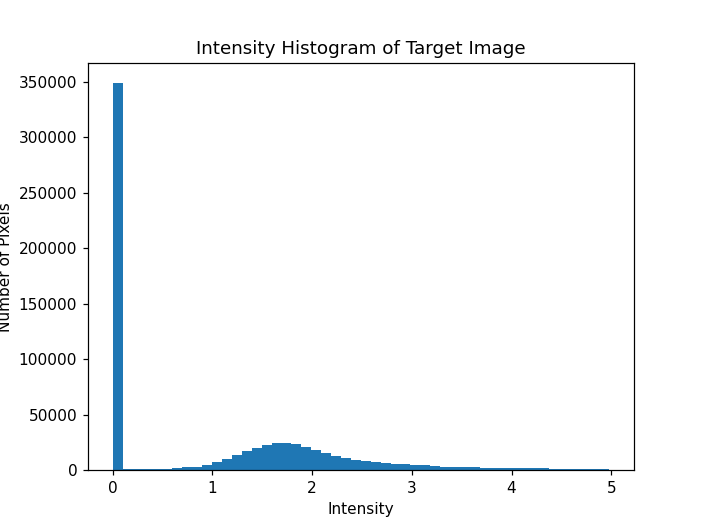

Text(0.5, 1.0, 'Intensity Histogram of Target Image')

In [13]:
# Intensity Histogram
fig,ax = plt.subplots()
ax.hist(J.ravel(), bins=50)
plt.xlabel('Intensity')
plt.ylabel('Number of Pixels')
plt.title('Intensity Histogram of Target Image')

In [14]:
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

sigmaA = 0.5 #standard deviation of artifact intensities
sigmaB = 0.3 #standard deviation of background intensities
sigmaM = 0.8 #standard deviation of matching tissue intenities

muA = torch.tensor([2.5,2.5,2.5],device=device) #average of artifact intensities

muB = torch.tensor([0,0,0],device=device) #average of background intensities
print(muA,muB);

tensor([2.5000, 2.5000, 2.5000], device='cuda:0') tensor([0, 0, 0], device='cuda:0')


In [15]:
slice_offset = -2
slice += slice_offset # correcting for offset

In [16]:
# initialize variables
scale_x = 0.08 #default = 0.9
scale_y = 0.08 #default = 0.9
scale_z = 0.9 #default = 0.9
theta0 = (np.pi/180)*theta_deg

# get an initial guess
if 'Ti' in locals():
    T = np.array([-xI[0][slice],np.mean(xJ[0])-(Ti[0]*scale_y),np.mean(xJ[1])-(Ti[1]*scale_x)])
else:
    T = np.array([-xI[0][slice],np.mean(xJ[0]),np.mean(xJ[1])])

scale_atlas = np.array([[scale_z,0,0],
                        [0,scale_x,0],
                        [0,0,scale_y]])
L = np.array([[1.0,0.0,0.0],
             [0.0,np.cos(theta0),-np.sin(theta0)],
              [0.0,np.sin(theta0),np.cos(theta0)]])
L = np.matmul(L,scale_atlas)#np.identity(3)

Actually Running STalign

<IPython.core.display.Javascript object>


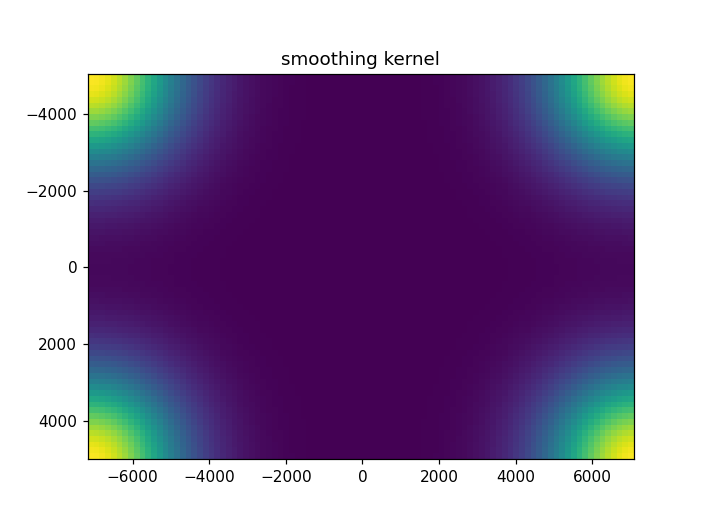

<IPython.core.display.Javascript object>


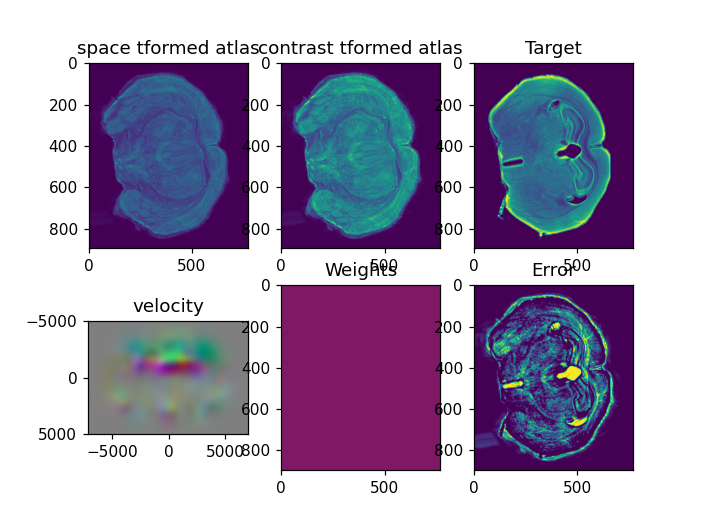

<IPython.core.display.Javascript object>


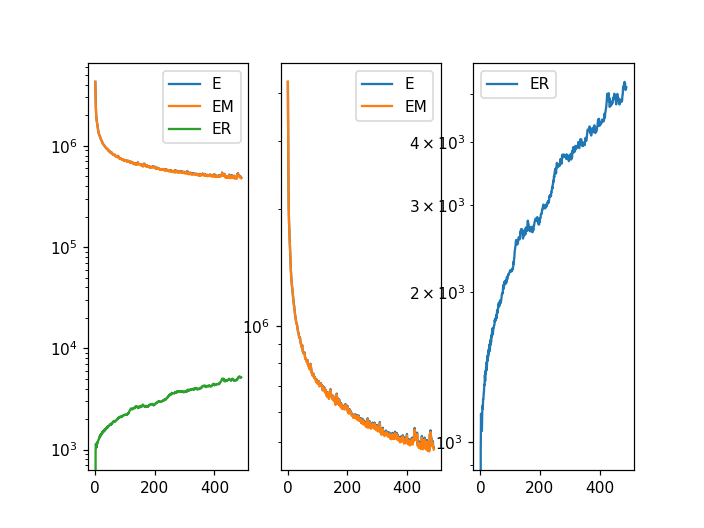

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
CPU times: total: 4min 39s
Wall time: 1min 5s


In [18]:
%%time

# run LDDMM

#returns mat = affine transform, v = velocity, xv = pixel locations of velocity points
transform = STalign.LDDMM_3D_to_slice(
    xI,I,xJ,J,
    T=T,L=L,
    nt=4,niter=500,
    device=device,
    sigmaA = sigmaA, #standard deviation of artifact intensities
    sigmaB = sigmaB, #standard deviation of background intensities
    sigmaM = sigmaM, #standard deviation of matching tissue intenities
    muA = muA, #average of artifact intensities
    muB = muB, #average of background intensities
    a = 300,
    epL = 1e-10,
    epT = 1e-9,
    epV = 1e3,
    sigmaR = 1e9
)

In [ ]:
# Saving all relavant variables
import pickle

# Saving transform
filename = 'transform_hyopil_2.pickle'
with open(filename,'wb') as file:
    pickle.dump(transform, file)
    print('transform check')
    pickle.dump(W,file)
    print('W check')
    pickle.dump(xJ,file)
print("stored")
